In [137]:
import tcod.map
import numpy as np
import matplotlib.pyplot as plt
import skimage.draw
import random

### Blueprint

blueprint is a 2D walkable array. Its sized is slightly larger than the game_map, with padded rows and columns (2 on all four sides). The paddings are used to create wall masks by moving the array in all cardinal/intermediate directions, and combining theses 8 boolean arrays. 2 rows/columns are need to create the 3d effect of the walls.

In [138]:
MAP_WIDTH = 80
MAP_HEIGHT = 43
blueprint = np.zeros((MAP_HEIGHT + 4, MAP_WIDTH + 4), dtype=np.bool_)

### Room Prefab

prefab.py contain rooms that defines it's walkable areas. Built on top of skimage.draw functions, it can:
- find it's centre
- return `True` if it intercept with another room
- draw shapes on the blueprint array. 

Also contains horizontal, vertical & diagonal tunnels which connect 2 rooms together.

#### 1. Base Class

In [139]:
## just need to define rr, cc walkable coordinates

class Room:
    def __init__(self, x, y, w, h):
        self.x1 = x
        self.y1 = y
        self.x2 = x + w
        self.y2 = y + h
        self.rr = None
        self.cc = None
    
    def center(self):
        cx = int(np.median(self.cc))
        cy = int(np.median(self.rr))
        return cy, cx,

    def intersect(self, other):
        return (
            self.x1 <= other.x2 and
            self.x2 >= other.x1 and
            self.y1 <= (other.y2 + 2) and
            self.y2 >= (other.y1 - 2)
        )

    def draw(self, array):
        array[self.rr, self.cc] = True

#### 2. Rectanglular Room

In [140]:
class Rect(Room):
    def __init__(self, x, y, w, h):
        super().__init__(x, y, w, h)

        self.rr, self.cc = skimage.draw.polygon(
            r=[y, y + h, y + h, y],
            c=[x, x, x + w, x + w]
        )

In [141]:
def show(array):
    """helper function, visualize the array"""
    plt.figure(figsize=(3,3))
    plt.imshow(
        array,
        cmap=plt.cm.Accent_r,
        interpolation='nearest'
    )
    plt.xticks([]),plt.yticks([])
    plt.show()

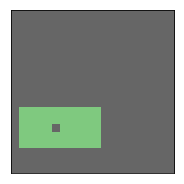

In [142]:
w = random.randint(4, 10)
h = random.randint(4, 10)
x = random.randint(1, 20 - w - 1)
y = random.randint(1, 20 - h - 1)

array = np.zeros((20, 20), dtype=np.bool_)
room = Rect(x,y,w,h)
room.draw(array)

cy, cx = room.center()
array[cy, cx] = False
show(array)

#### 3. Circular Room

In [143]:
class Ellipse(Room):
    def __init__(self, x, y, w, h):
        super().__init__(x, y, w, h)
        self.rr, self.cc = skimage.draw.ellipse(
            r=int(y+h/2),
            c=int(x+w/2),
            r_radius=int(h/2),
            c_radius=int(w/2),
            rotation=random.randint(0, 360)
        )

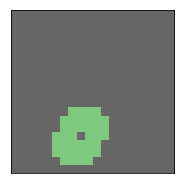

In [144]:
w = random.randint(4, 8)
h = random.randint(4, 8)
x = random.randint(1, 20 - w - 1)
y = random.randint(1, 20 - h - 1)

array = np.zeros((20, 20), dtype=np.bool_)
room = Ellipse(x,y,w,h)
room.draw(array)

cy, cx = room.center()
array[cy, cx] = False
show(array)

#### 4. Irregular Shaped Room

In [145]:
class Irregular(Room):
    def __init__(self, x, y, w, h, map_width=80, map_height=40, is_rect=True):
        super().__init__(x, y, w, h)
        self.rr, self.cc = self._coordinates(w, h, map_width, map_height, is_rect)
        
    def _coordinates(self, w, h, map_width, map_height, is_rect):
        while True:
            
            angle = np.linspace(0, 2 * np.pi, 50)
            r_circle = np.sqrt((w/2)**2 + (h/2)**2)
            
            # different x, y here
            # represent the circle coordinates
            x = np.round(np.cos(angle)*r_circle, 2)
            y = np.round(np.sin(angle)*r_circle, 2)

            # rectangle coordinates
            if is_rect:
                x[x > w/2] = w/2
                x[x < -w/2] = -w/2
                y[y > h/2] = h/2
                y[y < -h/2] = -h/2

            # noise for x coordinate
            noise1 = tcod.noise.Noise(
                dimensions=1,
                algorithm=tcod.NOISE_SIMPLEX,
                implementation=tcod.noise.FBM,
                hurst=0.5,
                lacunarity=2,
                octaves=4,
            )

            # noise for y coordinate
            noise2 = tcod.noise.Noise(
                dimensions=1,
                algorithm=tcod.NOISE_SIMPLEX,
                implementation=tcod.noise.FBM,
                hurst=0.5,
                lacunarity=2,
                octaves=4,
            )

            # Return the sampled noise from the grid of points.
            xn = noise1.sample_ogrid([angle])
            yn = noise2.sample_ogrid([angle])

            # start and end return to zero
            xn[:20] = xn[:20] * np.arange(0, 1, 0.05)
            xn[-20:] = xn[-20:] * np.arange(1, 0, -0.05)
            yn[:20] = yn[:20] * np.arange(0, 1, 0.05)
            yn[-20:] = yn[-20:] * np.arange(1, 0, -0.05)

            # add noise 
            x = x + x * xn
            y = y + y * yn

            # move origin point
            x = self.x1 + x - min(x) #+ 3
            y = self.y1 + y - min(y) #+ 4

            # update width, height
            self.x2 = int(self.x1 + max(x) - min(x)) 
            self.y2 = int(self.y1 + max(y) - min(y)) 

            # move room back in bound
            if self.x2 >= map_width-1:
                diff = int(self.x2 - map_width) + 2
                x -= diff
                self.x1 -= diff
                self.x2 -= diff

            if self.y2 >= map_height-1:
                diff = int(self.y2 -map_height) + 2
                y -= diff
                self.y1 -= diff
                self.y2 -= diff

            if self.x1 <= 0:
                diff = -self.x1 + 2
                x += diff
                self.x1 += diff
                self.x2 += diff

            if self.y1 <= 0:
                diff = -self.y1 + 2
                y += diff
                self.y1 += diff
                self.y2 += diff
            
            # there's a bug somewhere... Make sure its definitely in bound 
            if self.x1>0 or self.x2>0 or self.y2<map_height or self.x2<map_width:
                return skimage.draw.polygon(y, x)


#### 4a. Irregular Rectangular Room

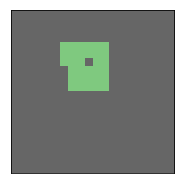

In [146]:
map_width = 20
map_height = 20

w = random.randint(4, 9)
h = random.randint(4, 7)
x = random.randint(1, map_width - w - 1)
y = random.randint(1, map_height - h - 1)

array = np.zeros((map_height, map_width), dtype=np.bool_)
room = Irregular(x,y,w,h, map_width, map_height, is_rect=True)
room.draw(array)

cy, cx = room.center()
array[cy, cx] = False
show(array)

#### 4b. Irregular Circular Room

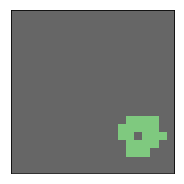

In [147]:
map_width = 20
map_height = 20

r = random.randint(3, 6)

x = random.randint(1, map_width - w - 1)
y = random.randint(1, map_height - h - 1)

array = np.zeros((map_height, map_width), dtype=np.bool_)
room = Irregular(x,y,r,r, map_width, map_height, is_rect=False)
room.draw(array)

cy, cx = room.center()
array[cy, cx] = False
show(array)

#### 5. Horizontal and Vertical Tunnel

In [148]:
def draw_horizontal_tunnel(array, x1, x2, y):
    array[y, min(x1, x2):max(x1, x2) + 1] = True


def create_vertical_tunnel(array, y1, y2, x):
    array[min(y1, y2):max(y1, y2) + 1, x] = True
    

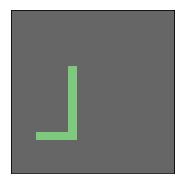

In [149]:
map_width = 20
map_height = 20

prev_x = random.randint(1, map_width - 1)
new_x =  random.randint(1, map_width - 1)
prev_y = random.randint(1, map_height - 1)
new_y = random.randint(1, map_height - 1)

array = np.zeros((map_height, map_width), dtype=np.bool_)
draw_horizontal_tunnel(array, prev_x, new_x, prev_y)
create_vertical_tunnel(array, prev_y, new_y, new_x)

show(array)

#### 6. Diagonal Tunnel

In [150]:
def draw_diagonal_tunnel(array, x1, y1, x2, y2):
    x_offset, y_offset = 0, 0
    x_diff = max(x2, x1) - min(x2, x1)
    y_diff = max(y2, y1) - min(y2, y1)
    if  x_diff > y_diff:
        x_offset = 1
    else:
        y_offset = 1

    rr1, cc1 = skimage.draw.line(y1, x1, y2, x2)
    rr2, cc2 = skimage.draw.line(y1 + y_offset , x1+x_offset, y2 + y_offset, x2+x_offset)
    array[rr1, cc1] = True
    array[rr2, cc2] = True

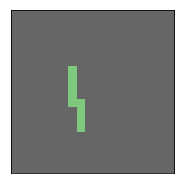

In [151]:
# there is small chance that the line is drawn out of bound, resulting in an error

map_width = 20
map_height = 20

prev_x = random.randint(1, map_width - 1)
new_x =  random.randint(1, map_width - 1)
prev_y = random.randint(1, map_height - 1)
new_y = random.randint(1, map_height - 1)

try:
    array = np.zeros((map_height, map_width), dtype=np.bool_)
    draw_diagonal_tunnel(array, prev_y,prev_x, new_y, new_y)
    show(array)
except:
    pass

### Generation

Randomly place the room on the blueprint and connect them with tunnels.

In [152]:
b = np.zeros((80 + 4, 54 + 4), dtype=np.bool_)
b.shape

(84, 58)

In [153]:
b[2:-2, 2:-2].shape

(80, 54)

In [154]:
class Level:
    def __init__(self, max_rooms, room_min_size, room_max_size, map_width, map_height):
        self.blueprint = np.zeros((map_height + 5, map_width + 5), dtype=np.bool_)
        self.blueprint_cropped = self.blueprint[2:-2, 2:-3]
        self.max_rooms = max_rooms
        self.room_min_size = room_min_size
        self.room_max_size = room_max_size
        self.map_width = map_width
        self.map_height = map_height
        self.room_intersected = 0
        self.rooms = []
    
    def _gen_room(self):
        """used in _make_blueprint() method"""
        
        while True:
            # randomized room location, size and it's type
            w = random.randint(self.room_min_size, self.room_max_size)
            h = random.randint(self.room_min_size, self.room_max_size)
            x = random.randint(1, self.map_width - w - 1)
            y = random.randint(1, self.map_height - h - 1)
            room_type = random.random()
            
            # room type probability
            if room_type < 0.6:
                room = Irregular(x, y, min(w, 9) , min(h, 7), self.map_width, self.map_height,  is_rect=True)
            elif room_type < 0.95:
                room = Irregular(x, y, min(w, 6) , min(h, 6), self.map_width, self.map_height,  is_rect=False)
            else:
                room = Ellipse(x, y, w, h)
    
            for r in self.rooms:
                if room.intersect(r):
                    break
            else:
                self.rooms.append(room) 
                break
        
        # draw room on blueprint
        room.draw(self.blueprint_cropped)

    def _gen_corridor(self):
        """used in _make_blueprint() method"""
        # get room centre coordinates
        new_y, new_x  = self.rooms[-1].center()
        prev_y, prev_x = self.rooms[-2].center()
        tunnel_type = random.random()
        
        # tunnel type probability
        if tunnel_type < 0.425:
            draw_horizontal_tunnel(self.blueprint_cropped, prev_x, new_x, prev_y)
            create_vertical_tunnel(self.blueprint_cropped, prev_y, new_y, new_x)
        elif tunnel_type < 0.85:
            create_vertical_tunnel(self.blueprint_cropped, prev_y, new_y, prev_x)
            draw_horizontal_tunnel(self.blueprint_cropped, prev_x, new_x, new_y)
        else:
            draw_diagonal_tunnel(self.blueprint_cropped, prev_x, prev_y, new_x, new_y)

    def _make_blueprint(self):
        for r in range(self.max_rooms):
            self._gen_room()
            if len(self.rooms) > 1:
                self._gen_corridor()
                
    def _inspect_blueprint(self):
        """after using _make_blueprint() method, plot a graph"""
        plt.imshow(
            self.blueprint,
            cmap=plt.cm.Accent_r,
            interpolation='nearest'
        )
        plt.xticks([]),plt.yticks([])
        plt.show()

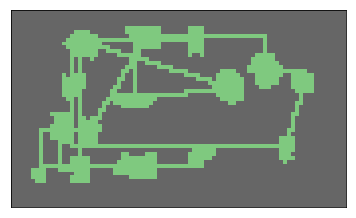

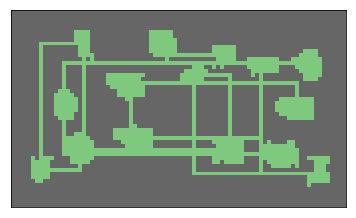

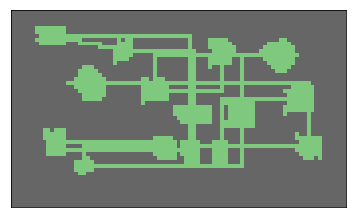

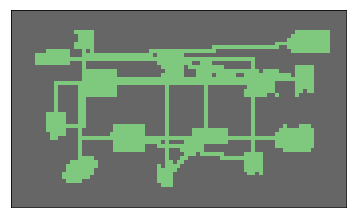

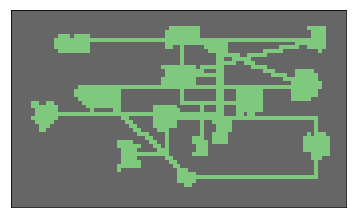

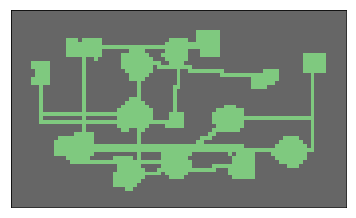

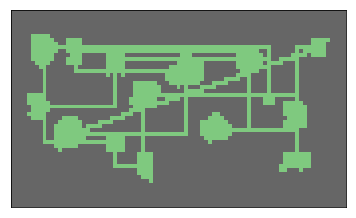

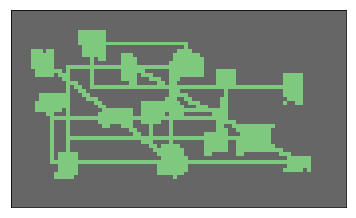

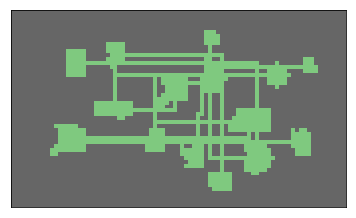

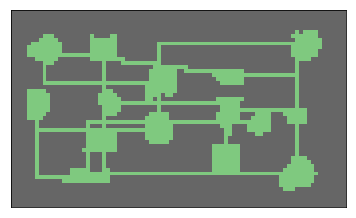

In [155]:
for _ in range(10):
    lvl = Level(15, 4, 10, 80, 45)
    lvl._make_blueprint()
    lvl._inspect_blueprint()

In [156]:
class GameMap(tcod.map.Map):
    def __init__(self, width, height):
        # self.width = width
        # self.height = height
        # self.transparent = np.zeros((height, width), dtype=np.bool_)
        # self.walkable = np.zeros((height, width), dtype=np.bool_)
        # self.fov = np.zeros((height, width), dtype=np.bool_)
        self.explored = np.zeros((height, width), dtype=np.bool_)
        self.ch = np.zeros((height, width), dtype=np.intc)
        self.fg = np.zeros((height, width), dtype='(3,)u1')
        self.bg = np.zeros((height, width), dtype='(3,)u1')
        super().__init__(width, height)

In [157]:
def make_map(blueprint):
    
    
    # move room in all direction, use the mask as the wall
    # to create the 3d effect, move picture north and south by 2
    floor = blueprint[2:-2, 2:-2]
    
    
    nw_roof = floor < blueprint[3:-1, 3:-1]
    ne_roof = floor < blueprint[3:-1, 1:-3]
    sw_roof = floor < blueprint[1:-3, 3:-1]
    se_roof = floor < blueprint[1:-3, 1:-3]
    n_roof = floor < blueprint[3:-1, 2:-2]
    s_roof = floor < blueprint[1:-3, 2:-2]
    w_roof = floor < blueprint[2:-2, 3:-1]
    e_roof = floor < blueprint[2:-2, 1:-3]
    lnw_roof = floor < blueprint[4:, 3:-1]
    lne_roof = floor < blueprint[4:, 1:-3]
    lsw_roof = floor < blueprint[:-4, 3:-1]
    lse_roof = floor < blueprint[:-4, 1:-3]
    ln_roof = floor < blueprint[4:, 2:-2]
    ls_roof = floor < blueprint[:-4, 2:-2]
    w_roof = floor < blueprint[2:-2, 3:-1]
    e_roof = floor < blueprint[2:-2, 1:-3]

    roof_wall = (
        ln_roof + lnw_roof + lne_roof + 
        ls_roof + lsw_roof + lse_roof + 
        n_roof + nw_roof + ne_roof +
        s_roof + sw_roof + se_roof + 
        e_roof + w_roof
    )
    
    
    # create wall and roof
    char = roof_wall[:-1] << roof_wall[1:]
    char = char.astype(np.int16)

    # remove wall with no roof
    wall_with_no_roof = (char == 1)[1:-1,1:-1] & (char == 0)[0:-2,1:-1]
    char[1:-1,1:-1][wall_with_no_roof] = 247 # water
    
    # change number to tileset
    char[(floor[:-1] == 1)] = 249 # floor
    char[char == 1] = 176 # wall
    char[char == 2] = 219 # roof
    
    
    game_map = GameMap(MAP_WIDTH, MAP_HEIGHT)
    game_map.walkable[:] = floor[:-1,1:]
    game_map.transparent[:] = floor[:-1,1:] + floor[1:,1:]
    game_map.ch[:] = char[:,1:]
    
    
    game_map.fg[:] = (220, 220, 220) # white
    game_map.fg[char[:,1:] == 247] = (0, 120, 255) # water = blue
    game_map.bg[:] = (30, 20, 10) # black
    return game_map

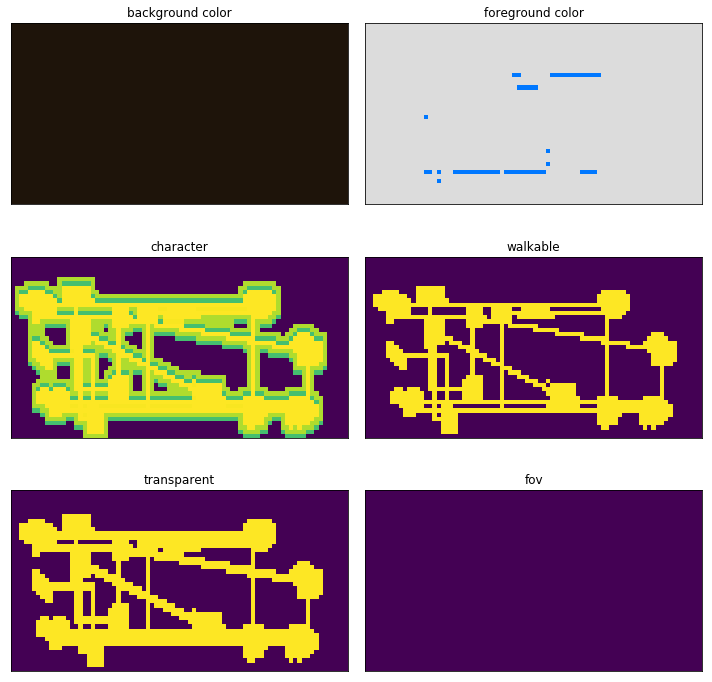

In [158]:
lvl = Level(15, 4, 10, MAP_WIDTH, MAP_HEIGHT)
lvl._make_blueprint()
game_map = make_map(lvl.blueprint)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()
axs[0].imshow(game_map.bg)
axs[0].set_title('background color')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(game_map.fg)
axs[1].set_title('foreground color')
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[2].imshow(game_map.ch)
axs[2].set_title('character')
axs[2].set_xticks([])
axs[2].set_yticks([])

axs[3].imshow(game_map.walkable)
axs[3].set_title('walkable')
axs[3].set_xticks([])
axs[3].set_yticks([])

axs[4].imshow(game_map.transparent)
axs[4].set_title('transparent')
axs[4].set_xticks([])
axs[4].set_yticks([])

axs[5].imshow(game_map.fov)
axs[5].set_title('fov')
axs[5].set_xticks([])
axs[5].set_yticks([])

plt.tight_layout()
plt.show()